# Q1: PyTorch Backward Hooks

#### README
Q1: Backward hooks (Part 1)
- Set path to imagenet folder: --img_path './imgnet500'
- Set folder to save l2 gradient vectors: --save_folder_path = "./save_grad_norms/"
- Run calculate_norms(img_path, save_folder_path)

Q1: Backward hooks (Part 2)
- Set folder of saved l2 gradient vectors: --save_folder_path = "./save_grad_norms/"
- Run plot(save_folder_path)

In [1]:
# import libraries
import os
import PIL.Image
from torch.utils.data import Dataset
from torchvision import models
from torchvision import transforms
import torch
from torch import nn
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# dataset
class dataset_imagenetvalpart(Dataset):
  def __init__(self, root_dir, maxnum, skip=0, transform=None):

    """
    Args:

        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """

    self.root_dir = root_dir
    self.transform = transforms.Compose([transforms.Resize(224),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])    
    self.imgfilenames=[]
    self.ending=".JPEG"
    
    allfiles=[]
    for root, dirs, files in os.walk(self.root_dir):
      allfiles.extend(files)
    allfiles = sorted(allfiles)

    for ct,name in enumerate(allfiles):
      if ct < skip:
        continue
        
      nm=os.path.join(root, name)
      if (maxnum >0) and ct>= (maxnum + skip):
        break
      self.imgfilenames.append(nm)

  def __len__(self):
      return len(self.imgfilenames)

  def __getitem__(self, idx):
    image = PIL.Image.open(self.imgfilenames[idx]).convert('RGB')

    if self.transform:
      image = self.transform(image)

    sample = {'image': image, 'filename': self.imgfilenames[idx]}

    return sample

In [3]:
# Q1: Backward hooks for analysing gradient statistics (Calculating grad norms)
def gb_bw_hook(filepath, img_name):   
    def bw_hook(module, grad_input, grad_output):
        return save_grad_norm(module, grad_input, grad_output, filepath, img_name)
    return bw_hook

def save_grad_norm(module, grad_input, grad_output, filepath, img_name):    
    gradient = grad_output[0].detach().cpu()
    channel_gradient_norm = torch.norm(gradient, dim=(2,3)).squeeze(0).clone().to('cpu').numpy()     
    file_stub = os.path.basename(img_name).split('.')[0]
    full_img_path = os.path.join(filepath, '{}.npy'.format(file_stub))
    np.save(full_img_path, channel_gradient_norm)

def compute_grad_norm(model, dataset, save_folder_path, total_images):    
    
    print("- start computing gradient norms for {} -".format(model.name))
    
    num_layer = 0
    module_list = []
    for module in model.modules():   
        if isinstance(module, torch.nn.modules.conv.Conv2d):
            num_layer += 1
            module_list.append(module)
            if num_layer == 2:
                break

    os.makedirs(save_folder_path, exist_ok=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device) 
    
    count = 0
    for data in dataset: 
        count += 1
        img_name = data['filename']
        inputs = data['image'].unsqueeze(0).to(device)  
        
        handles = []
        
        for i in range(2):
            filepath = os.path.join(save_folder_path, os.path.join('layer{}'.format(i), model.name)) 
            os.makedirs(filepath, exist_ok = True)
            handle = module_list[i].register_backward_hook(gb_bw_hook(filepath, img_name))
            handles.append(handle)
            
        model.zero_grad()
        output = model(inputs)
        
        with torch.no_grad():
            topclass = torch.max(output,1)[1]
            topclass = topclass.to(device)
        
        loss = criterion(output, topclass)
        loss.backward()
        
        for handle in handles:
            handle.remove()            
        
        if count % 50 == 0:
            print("Completed {}/{} images.".format(count, total_images))

        if count == total_images:        
            break   
    
    print("- completed computing gradient norms for {} -".format(model.name))

def calculate_norms(img_path, save_folder_path):
    #vgg16
    vgg16 = models.vgg16(pretrained=True)
    vgg16.name = 'vgg16'
    vgg16.eval()

    #vgg16_bn
    vgg16_bn = models.vgg16_bn(pretrained=True)
    vgg16_bn.name = 'vgg16_bn'
    vgg16_bn.eval()

    # Create dataset
    dataset = dataset_imagenetvalpart(img_path, 500)

    total_images = 250

    # Compute and save grad norm for vgg16
    compute_grad_norm(vgg16, dataset, save_folder_path, total_images)

    # Compute and save grad norm for vgg16_bn
    compute_grad_norm(vgg16_bn, dataset, save_folder_path, total_images)

img_path = './imgnet500'
save_folder_path = "./save_grad_norms/"
calculate_norms(img_path, save_folder_path)

- start computing gradient norms for vgg16 -
Completed 50/250 images.
Completed 100/250 images.
Completed 150/250 images.
Completed 200/250 images.
Completed 250/250 images.
- completed computing gradient norms for vgg16 -
- start computing gradient norms for vgg16_bn -
Completed 50/250 images.
Completed 100/250 images.
Completed 150/250 images.
Completed 200/250 images.
Completed 250/250 images.
- completed computing gradient norms for vgg16_bn -


Plot percentiles per channel:


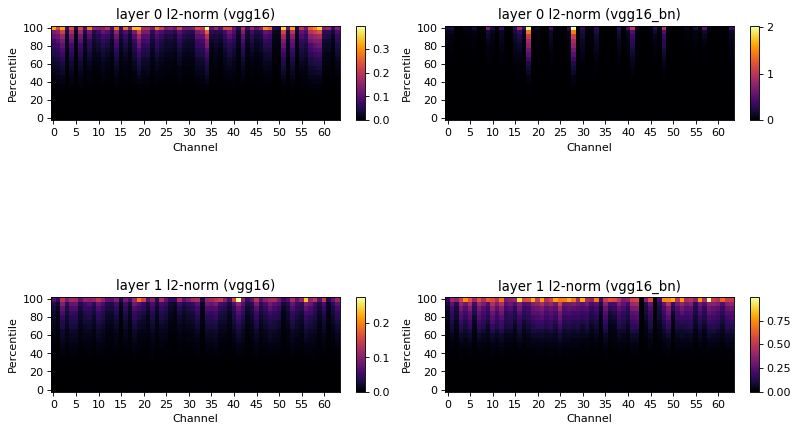

Plot median per channel:


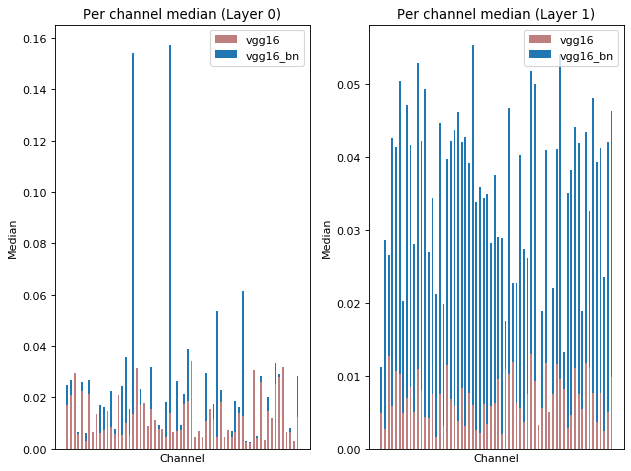

In [4]:
# Q1: Backward hooks for analysing gradient statistics (Plotting l2 norms)
def load_data(save_norms_folder): 
    
    layer_data = []
    
    for file in os.listdir(save_norms_folder):        
        layer_path = os.path.join(save_norms_folder, file)        
        data_dict = defaultdict(lambda: [])
        model_paths = []
        
        for modelname in os.listdir(layer_path):             
            data_dict['modelname'].append(modelname)
            model_paths.append(os.path.join(layer_path, modelname))
            
        data_dict['modelname'] = sorted(data_dict['modelname'])
        model_paths = sorted(model_paths)
        
        for model_path in model_paths:      
            img_path = [os.path.join(model_path, imgname) for imgname in os.listdir(model_path)]                   
            num_channels = np.load(img_path[0]).shape[0]      
            data_dict['channels'].append(num_channels)            
            data = []                      
            for k in range(len(img_path)):
                channels_data = np.load(img_path[k]) 
                data.append(channels_data)        
            data_dict['data'].append(np.array(data))  
            
        layer_data.append(data_dict)
        
    return layer_data

def plot_percentiles(layer_datas):
    print("Plot percentiles per channel:")
    
    layer_count = len(layer_datas)
    model_count = len(layer_datas[0]['modelname'])
    fig, axes = plt.subplots(model_count, layer_count, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    
    for layer in range(layer_count):
        datas = layer_datas[layer]
        percentiles = [str(j) for j in range(100, -5, -5)]
        
        for model in range(model_count):
            channel_count = datas['channels'][model]
            channels = [str(i + 1) for i in range(channel_count)]
            ax = axes[layer, model]
            data = datas['data'][model]
            graphinfo = np.zeros((len(percentiles), channel_count))
            
            for i in range(len(percentiles)):
                graphinfo[i, :] = np.percentile(data, int(percentiles[i]), 0)
                
            im = ax.imshow(graphinfo, cmap='inferno')            
            divider = make_axes_locatable(ax)
            
            cax = divider.append_axes("right", size="3%", pad=0.2)
            cbar = ax.figure.colorbar(im, cax=cax)
            cbar.ax.set_ylabel("", rotation=-90, va="bottom")  
            
            channel_len = len(channels)
            percentiles_len = len(percentiles)
            
            ax.set_xticks(np.arange(0, channel_len, 5))
            ax.set_yticks(np.arange(0, percentiles_len, 4))        
            ax.set_xticklabels(np.arange(0, channel_len, 5))
            ax.set_yticklabels([i for i in range(100, -5, -20)])
            ax.set_ylabel("Percentile")
            ax.set_xlabel("Channel")           
            ax.set_title('layer {} l2-norm ({})'.format(layer, layer_datas[layer]['modelname'][model]))
            
    fig.tight_layout()
    plt.show()


def plot_medians(layer_datas):
    print("Plot median per channel:")
    layer_count = len(layer_datas)
    model_count = len(layer_datas[0]['modelname'])
    fig, axes = plt.subplots(1, layer_count, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    width = 0.50
    for layer in range(layer_count):
        ax = axes[layer]
        data_dict = layer_datas[layer]
        data = data_dict['data']
        channel_arr = []
        medians = {}
        for model in range(model_count):
            medians[model] = np.median(data[model], 0)
            channel_arr.append(np.arange(data_dict['channels'][model]))
        layer1 = ax.bar(channel_arr[0], medians[0], width, label=data_dict['modelname'][0],color=(0.5, 0, 0, 0.5))
        layer2 = ax.bar(channel_arr[1], medians[1], width, label=data_dict['modelname'][1], bottom=medians[0])
        ax.set_ylabel("Median")
        ax.set_xlabel("Channel")
        ax.set_xticks([])
        ax.legend()
        ax.set_title('Per channel median (Layer {})'.format(layer))
    fig.tight_layout()
    plt.show()

def plot(save_norms_folder):
    # Load l2 norms from file
#     save_norms_folder = "./save_grad_norms/"
    layer_data = load_data(save_norms_folder)  
    # Plot percentiles per channel
    plot_percentiles(layer_data)
    # Plot median per channel
    plot_medians(layer_data)

save_folder_path = "./save_grad_norms/"
plot(save_folder_path)